In [ ]:
! git clone https://github.com/matteobreschi/bajes.git

In [ ]:
!pip install pycbc lalsuite ligo-common #might have to restart runtime before this cell works
!pip install gwpy

import gwpy
from gwpy.timeseries import TimeSeries

In [ ]:
%cd bajes
! ls
! python setup.py install

In [ ]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bajes.obs.gw import Series
from bajes.obs.gw import Noise
from bajes.obs.gw.utils import read_asd
import csv
import pandas as pd

from google.colab import drive #import drive so csv file wont just save during runtime
drive.mount('/content/drive/', force_remount = True)



In [5]:
time_of_event = 1126259462

post_trigger_duration =4
duration = 8
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

t = H1_analysis_data.times
strain = H1_analysis_data.value

# set the data properties coherently
seglen = 8           # duration of the segment [s]
srate  = 4096         # sampling rate [Hz]
t_gps  = 1126259462   # central value of GPS time
f_max  = 1024
f_min  = 20 

series = Series('time', strain, seglen=seglen, srate=srate, t_gps=t_gps, f_min=f_min, f_max=f_max)

from bajes.obs.gw import Noise
from bajes.obs.gw.utils import read_asd

fr_asd, asd = read_asd('GW150914', 'H1')
noise       = Noise(fr_asd, asd, f_min=0, f_max=f_max)

from bajes.obs.gw import Detector, Waveform

wave  = Waveform(series.freqs, srate, seglen, 'NRPM')

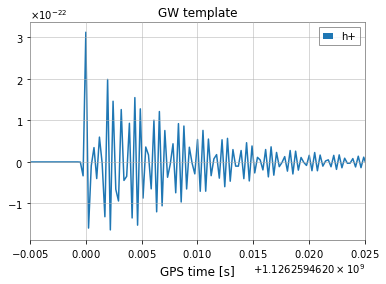

In [6]:

import math
import random

#get a float random number between 1-3, and round the number to one decimal place for the binary neutron star masses
m1 = round(random.uniform(1, 3), 1) 
m2 = round(random.uniform(1, 3), 1)

# m1 has to be bigger than m2 for the proper mass ratio 
if m1 > m2:
  chirp_mass = (math.pow((m1 * m2), (3/5))) / (math.pow((m1 + m2), (1/5))) 
  q = m1 / m2  #calculates the mass ratio
elif m1 < m2:
  while m1 < m2:
    m1 = round(random.uniform(1, 3), 1)
    m2 = round(random.uniform(1, 3), 1)
chirp_mass = (math.pow((m1 * m2), (3/5))) / (math.pow((m1 + m2), (1/5)))
q = m1 / m2  

params = {'mchirp'     : chirp_mass,    # chirp mass [solar masses] 
              'q'          : q,      # mass ratio 
              's1x'        : 0.,      # primary spin parameter, x component
              's1y'        : 0.,      # primary spin parameter, y component
              's1z'        : 0.,      # primary spin parameter, z component
              's2x'        : 0.,      # secondary spin parameter, x component
              's2y'        : 0.,      # secondary spin parameter, y component
              's2z'        : 0.,      # secondary spin parameter, z component
              'lambda1'    : 400.,    # primary tidal parameter 
              'lambda2'    : 400. ,    # secondary tidal parameter
              'distance'   : 100.8114416513031,    # distance [Mpc]   
              'iota'       : np.pi,   # inclination [rad]   
              'ra'         : 0.,     # right ascension [rad]
              'dec'        : 0.,   # declination [rad]
              'psi'        : 0.,      # polarization angle [rad]
              'time_shift' : 0.419,   # time shift from GPS time [s]
              'phi_ref'    : 0.,      # phase shift [rad]
              'f_min'      : 20.,     # minimum frequency [Hz]
              'srate'      : srate,   # sampling rate [Hz]
              'seglen'     : seglen,  # segment duration [s] 
              'tukey'      : 0.1,     # parameter for tukey window
              't_gps'      : t_gps, 
             }  # GPS trigger time

hpc = wave.compute_hphc(params)

plt.title('GW template')
plt.plot(series.times, hpc.plus, label = 'h+')
plt.xlabel('GPS time [s]')
plt.xlim((t_gps-0.005, t_gps+0.025))
plt.legend() 


new_params = params #put params in new dictionary
new_params["m1"] = m1 #add m1 to new dictionary
new_params["m2"] = m2 #add m2 to new dictionary
new_params["mtot"] = round((m1 + m2), 1) #change mtot from params into a float with only 1 decimal point


In [7]:
#change the file name for each sim run
#document the masses so you can keep track of repeats
new_params["file name"] = "S00010.ipynb"
print(m1, m2)

2.1 1.9


In [8]:
#Run this cell for the very first run ONLY
#makes a data frame from new_params and makes a brand new csv file with it
'''df = pd.DataFrame.from_dict([new_params])
df.to_csv('/content/drive/MyDrive/Colab_Notebooks/metadata.csv', sep= '\t', index = False)''' 


In [8]:
#Run this cell for second run and up
#appends existing csv file
from csv import DictWriter

def append_dict_as_row(file_name, dict_of_elem, field_names):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        dict_writer = DictWriter(write_obj, delimiter = '\t', fieldnames=field_names, )
        # Add dictionary as wor in the csv
        dict_writer.writerow(dict_of_elem)

field_names = ['mchirp', 'q', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 
               'lambda1', 'lambda2', 'distance','iota', 'ra', 'dec', 'psi','time_shift',
               'phi_ref', 'f_min', 'srate', 'seglen', 'tukey', 't_gps', 'm1', 'm2', 'mtot', 'file name'
               ]

row_dict = new_params
# Append a dict as a row in csv file
append_dict_as_row('/content/drive/MyDrive/Colab_Notebooks/metadata.csv', row_dict, field_names)